# Project Details: 

Build a Support Vector Machine Model on Amazon Fine Food Reviews data set. Amazon Fine Food Reviews data set consists of reviews of fine foods from Amazon. <br>

Data source: https://www.kaggle.com/snap/amazon-fine-food-reviews 

#Reviews                   : 568,454 
#Users                     : 256,059 
#Products                  : 74,258 
 Time Span                 : Oct 1999 - Oct 2012
#Attributes/Columns in set : 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2). It is binary classification task. Ignore review rating  = 3.

Note: The baseline model (Naive Bayes with Tf-idf) has achieved 80% AUC, target is to get better auc measure than this with SVM even better than Logistic Regression (we got 71% f1 score and 87% AUC)



In [1]:
# ==================================================== Import Libraries ========================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3 # for importing data from sqlite database
import nltk #for Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer #for bag of words
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer # for term frequency/inverse document frequency of words
 # Model Performance measures
from sklearn.metrics import confusion_matrix , roc_curve, auc, accuracy_score, precision_recall_fscore_support
import re # References for Regular Expressions: https://docs.python.org/3/howto/regex.html, https://regexr.com/2vhbb
import warnings
from nltk.corpus import stopwords
from wordcloud import WordCloud
from gensim.models import Word2Vec
warnings.simplefilter('ignore')
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm_notebook as tqdm
import itertools
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C:\Users\vajrapra\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


The data that we are using is already pre-processed and is saved in a sqlite database. The pre-processing steps are as below:

Text cannot be used as is, has to be converted into some numeric form (likes arrays or vectors of numbers) to be
used as feature in the model. But before that there is a need to process the text. 
1. Removing html tags (if any), since the urls does not add any information to the data.
2. Removing punctuations, non-alphanumeric characters. 
3. Need to lower/upper the cases so that 'Peanuts' & 'peanuts' are considered same.
4. Removing Stop words like which, what, whether, articles etc.
5. Removing text with <3 word length.
6. Stemming of words to its root/base word so that run, running, runs all considered to be same. 

In [2]:
# =================================================== Importing Data ===========================================================
conn = sqlite3.connect('final.sqlite')
data = pd.read_sql_query('Select * from Reviews',conn) 
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,em_words,cleaned_sent,cleaned_sent_w2v
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,,have bought sever the vital can dog food produ...,have bought several the vitality canned dog fo...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,,product arriv label jumbo salt peanut the pean...,product arrived labeled jumbo salted peanuts t...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,,this confect that has been around few centuri ...,this confection that has been around few centu...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,,you are look for the secret ingredi robitussin...,you are looking for the secret ingredient robi...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,,great taffi great price there was wide assort ...,great taffy great price there was wide assortm...


In [3]:
# ============================================ Exploratory Data Analysis =====================================================
print(data.shape)

(328769, 14)


In [4]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,em_words,cleaned_sent,cleaned_sent_w2v
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,,have bought sever the vital can dog food produ...,have bought several the vitality canned dog fo...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,,product arriv label jumbo salt peanut the pean...,product arrived labeled jumbo salted peanuts t...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,,this confect that has been around few centuri ...,this confection that has been around few centu...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,,you are look for the secret ingredi robitussin...,you are looking for the secret ingredient robi...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,,great taffi great price there was wide assort ...,great taffy great price there was wide assortm...


Since, we have time in the data, we can make time based splitting of data into train and test.

In [5]:
## Time based Train, Test data
df = data.sort_values(by='Time')

train = df[:round(0.7*data.shape[0])]
test = df[round(0.7*data.shape[0]):]
#x_train,x_test,y_train,y_test = train_test_split(tr_tfidfw2v_features,train['label'], random_state = 3, test_size = 0.2)
print(df.shape)
print(train.shape)
print(test.shape)

(328769, 14)
(230138, 14)
(98631, 14)


In [6]:
## BOW: Bag of Words
count_vec = CountVectorizer(stop_words='english')
bow_words = count_vec.fit_transform(train['cleaned_sent'].values)
bow_words.shape

(230138, 57250)

In [7]:
np.isnan(bow_words.data).any()

False

In [8]:
## TF-IDF: Term Frequency-Inverse Document Frequency
tfidf_vec = TfidfVectorizer(stop_words = 'english',ngram_range=(1,2), max_df= 500, min_df = 2)
tfidf_words = tfidf_vec.fit_transform(train['cleaned_sent'])
tfidf_words.shape

(230138, 723876)

In [9]:
## Building Word2Vec model with train data
list_of_sent = [text.split() for text in train['cleaned_sent_w2v']]
w2v_model = Word2Vec(list_of_sent)

In [10]:
w2v_model.wv['great']

array([-1.4986039 , -0.25275734,  1.4846607 ,  3.029274  ,  2.5874174 ,
       -1.5854452 , -0.23923545, -0.3077701 ,  0.35964996,  0.8096133 ,
        3.450702  ,  0.4969116 ,  0.1374459 , -0.15564778, -0.4191808 ,
       -0.21047653, -0.5570611 , -2.066181  ,  1.3347604 , -2.631255  ,
       -0.02345878,  2.5330822 , -1.5220336 ,  0.41171837,  1.5853289 ,
        1.1618936 ,  0.7730905 , -2.9568462 ,  1.440942  , -2.099383  ,
       -1.2460945 , -0.43496892, -0.22011127,  1.3338948 , -2.7755833 ,
        1.6546797 , -0.07566851, -2.1922746 ,  1.8369675 ,  1.0539224 ,
        0.25319272, -1.3061155 ,  1.4806204 ,  1.0259925 , -0.56525475,
       -0.36015263, -0.56539744,  0.30521366,  1.1657944 ,  2.519826  ,
       -0.16550195,  0.47418863, -1.5021592 , -3.2697568 , -0.6804236 ,
        3.3315475 , -1.8994344 , -1.1490804 ,  0.84933114,  0.84215945,
       -2.222849  ,  0.92762154, -0.99305487, -0.74245346, -3.6835916 ,
       -2.852508  ,  3.0358624 ,  0.1904907 , -1.0128307 ,  0.10

In [11]:
## Avg W2V - Average Word2Vec based features
sent_vectors = []
count = 0
for text in tqdm(df['cleaned_sent_w2v'].values):
    counter = 0
    sent_vec = np.zeros(100)
    for word in text.split():
        try:
            word_vec = w2v_model.wv[word]
            sent_vec += word_vec
            counter +=1
        except:
            count +=1
            pass
    sent_vec /= counter
    sent_vectors.append(sent_vec)
print('#of words not present in word2vec model built on train set is:', count)

HBox(children=(IntProgress(value=0, max=328769), HTML(value='')))


#of words not present in word2vec model built on train set is: 134445


In [22]:
sent_vect = np.array(sent_vectors)
sent_vect = np.where(np.isnan(sent_vect), 0, sent_vect)

In [13]:
## TF-IDF W2V - Weighed average of word2vec based on tf-idf (weight) of the word
tfidfvec = TfidfVectorizer()
# give a matrix of all words, each cell represented by word has the tf-idf value
tfidfwords = tfidfvec.fit_transform(train['cleaned_sent_w2v']) 
dictionary = dict(zip(tfidfvec.get_feature_names(),list(tfidfvec.idf_))) # dict mapping of feature name as key and idf as value

list_of_sent = []
for sent in df['cleaned_sent_w2v'].values:
    list_of_sent.append(sent.split())

i = 0 # text row_id
tfidf_sent_vectors = []
for text in tqdm(list_of_sent):
    counter = 0
    sent_vec = np.zeros(100)
    tfidf_sent =0
    for word in text:
        try:
            word_vec = w2v_model.wv[word]
            tfidf_word = dictionary[word]*(text.count(word)/len(text))  # idf*tf
            sent_vec += word_vec*tfidf_word
            tfidf_sent += tfidf_word
        except:
            pass
    sent_vec /= tfidf_sent 
    tfidf_sent_vectors.append(sent_vec)
    i+=1

HBox(children=(IntProgress(value=0, max=328769), HTML(value='')))

In [23]:
tfidf_sent_vect = np.array(tfidf_sent_vectors)
tfidf_sent_vect = np.where(np.isnan(tfidf_sent_vect), 0, tfidf_sent_vect)

In [15]:
# Check for balance of classes
print(sum(df['Score']=='Positive')/df.shape[0])

0.8387439205034538


In [16]:
# UDF for Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          cmap=plt.cm.Blues):
    
    title = 'Confusion matrix, without normalization'
    plt.figure(figsize=(20, 4))
    plt.subplot(1,2,1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
     
    title = "Normalized confusion matrix"
    plt.subplot(1,2,2)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()   
    
def print_top10(vectorizer, clf, n):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))  

The dataset seems to be highly biased (4 times) towards Positive reviews, and hence is an imbalanced dataset. Data needs to be
balanced to train a model. Or we can penalise the error on Negative review 4 times than error on Positive review to make model
learning unbiased.


Support Vector Classification Model: It is a supervised, deterministic based model which finds a hyperplane or a decision surface with an objective of margin maximization for a minimal generalisation error. We will be training the data using RBF Kernel in SVM to get the support vectors and hence, the predictions. So, we have 2 hyper parameters to tune. One is the parameter C (balances the weight between objective function and regularization term) and other is the paramater Gamma which tunes the model to select the neighbor data points to generate support vectors, essentially controls the learning rate of the model. Higher the value of tuning parameter, higher the bias, underfitting is the model and viceversa. This can be achieved using Cross-Validation technique with different values of tuning parameters. And, pick the best of all.


And since this is a time based cross validation, the constraint on Validation set is to be always future in nature, with reference to the training subset of the model. So, in a K-fold time based validation, in kth split, first k folds are taken as train data and (k+1)th data set is taken as validation data. Essentially, every successive training sets are supersets of those that come before them.


Note: Read 'Test' as Validation set of the data.

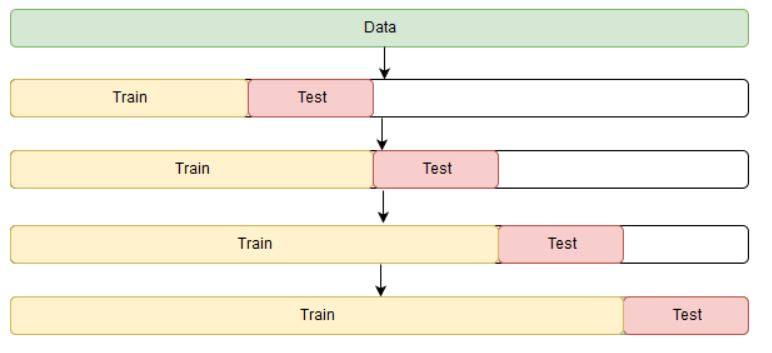



## ===================== SVM with Bag of Words features =========================

## SVM without Kernel with Grid Search Cross Validation

In [18]:
# 10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(max_train_size= None, n_splits= 10)
X = bow_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'alpha': [10 ** x for x in range(-4, 5)]}
gs_lin_bow_model = GridSearchCV(estimator = SGDClassifier(loss = 'hinge',class_weight= 'balanced', random_state= 100)\
                                                    ,param_grid = param,cv = tscv)
gs_lin_bow_model.fit(X,Y)

print(gs_lin_bow_model.best_estimator_)

SGDClassifier(alpha=1, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


To check the best tuning parameter, comparing the train and validation scores in a bias variance plot

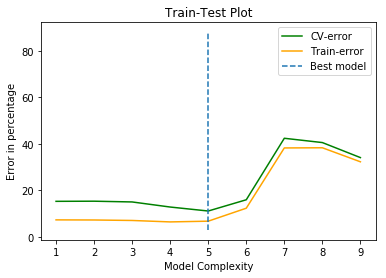

In [26]:
tscv_scores = gs_lin_bow_model.cv_results_.get('mean_test_score')
trcv_scores = gs_lin_bow_model.cv_results_.get('mean_train_score')
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(5,9),[3,9,15,28,38,48,58,68,88] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 1. So, picking up the best bag of words model with alpha = 1

In [27]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = False)
train_X = X_scaler.fit_transform(bow_words)
bow_words_tst1 = count_vec.transform(test['cleaned_sent'].values)
bow_words_tst = X_scaler.transform(bow_words_tst1)
classifier_name = SGDClassifier(loss = 'hinge',class_weight= 'balanced', random_state= 100,alpha = 1)
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_gs_lin_bow = classifier_name.fit(train_X,train_y)
predtest_y_gs_lin_bow = model_gs_lin_bow.predict(bow_words_tst)

# Accuracy score
gs_lin_acc_bow = accuracy_score(test_y, predtest_y_gs_lin_bow, normalize=True)*100
print("Test Accuracy for Linear SVM model with bag of words:",gs_lin_acc_bow,'%')
# Precision-Recall, f-score
gs_lin_bow_pre, gs_lin_bow_recall, gs_lin_bow_fscore, gs_lin_bow_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_gs_lin_bow,pos_label = 1, average = 'binary')
print("Test Precision for Linear SVM model with bag of words for Negative label reviews:",gs_lin_bow_pre)
print("Test Recall for Linear SVM model with bag of words for Negative label reviews:",gs_lin_bow_recall)
print("Test fscore for Linear SVM model with bag of words for Negative label reviews:",gs_lin_bow_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_gs_lin_bow, pos_label = 1)
gs_lin_bow_auc_score = auc(fpr,tpr)
print("Test AUC for  Linear SVM model with bag of words:",gs_lin_bow_auc_score)
# Confusion matrix
gs_lin_bow_cm = confusion_matrix(test_y, predtest_y_gs_lin_bow)

Test Accuracy for Linear SVM model with bag of words: 88.71855704595917 %
Test Precision for Linear SVM model with bag of words for Negative label reviews: 0.6463893249607535
Test Recall for Linear SVM model with bag of words for Negative label reviews: 0.8308390785269884
Test fscore for Linear SVM model with bag of words for Negative label reviews: 0.7270988153925392
Test AUC for  Linear SVM model with bag of words: 0.8652338727206051


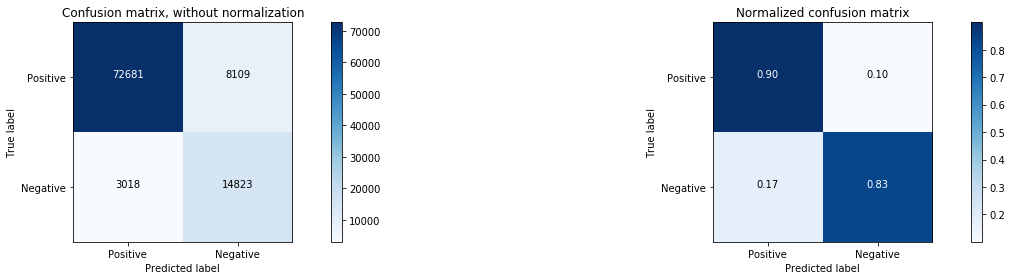

In [29]:
plot_confusion_matrix(gs_lin_bow_cm, ['Positive','Negative'])

#### Observations :

1. Linear SVM model with BOW seems to be a very good model compared to the best Logistic Regression model that we got in previous assignment.
2. AUC of 87% is achieved with f1 score of 72% and we have identified 83% of Negative reviews successfully though with 65% accuracy.

#### Top 5 features of BOW - Linear SVM Model

In [42]:
print("Top 5 features of Linear SVM model for positive and negative classes respectively:")
print_top10(count_vec,model_gs_lin_bow,5)

Top 5 features of Linear SVM model for positive and negative classes respectively:
	-0.1077	great          		0.0893	disappoint     
	-0.0891	love           		0.0475	worst          
	-0.0769	best           		0.0460	bad            
	-0.0613	delici         		0.0447	aw             
	-0.0538	good           		0.0445	terribl        


## SVM without Kernel with Random Search Cross Validation

In [37]:
# 10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(max_train_size= None, n_splits= 10)
X = bow_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'alpha': np.random.uniform(10**-2,10**2,10)}
rs_lin_bow_model = RandomizedSearchCV(estimator = SGDClassifier(loss = 'hinge',class_weight= 'balanced', random_state= 100)\
                                                    ,param_distributions = param,cv = tscv)
rs_lin_bow_model.fit(X,Y)

print(rs_lin_bow_model.best_estimator_)

SGDClassifier(alpha=11.57532616370065, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


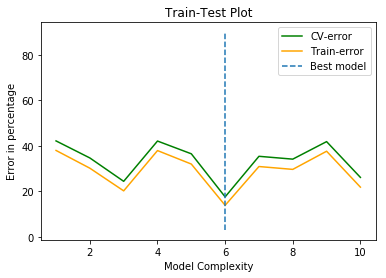

In [41]:
tscv_scores = rs_lin_bow_model.cv_results_.get('mean_test_score')
trcv_scores = rs_lin_bow_model.cv_results_.get('mean_train_score')
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9,10]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(6,10),[3,9,15,28,38,48,58,68,88,90] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 11.57532616370065. So, picking up the best bag of words model with alpha = 11.57532616370065

In [43]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = False)
train_X = X_scaler.fit_transform(bow_words)
bow_words_tst1 = count_vec.transform(test['cleaned_sent'].values)
bow_words_tst = X_scaler.transform(bow_words_tst1)
classifier_name = SGDClassifier(loss = 'hinge',class_weight= 'balanced', random_state= 100,alpha = 11.57532616370065)
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_rs_lin_bow = classifier_name.fit(train_X,train_y)
predtest_y_rs_lin_bow = model_rs_lin_bow.predict(bow_words_tst)

# Accuracy score
rs_lin_acc_bow = accuracy_score(test_y, predtest_y_rs_lin_bow, normalize=True)*100
print("Test Accuracy for Linear SVM model with bag of words:",rs_lin_acc_bow,'%')
# Precision-Recall, f-score
rs_lin_bow_pre, rs_lin_bow_recall, rs_lin_bow_fscore, rs_lin_bow_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_rs_lin_bow,pos_label = 1, average = 'binary')
print("Test Precision for Linear SVM model with bag of words for Negative label reviews:",rs_lin_bow_pre)
print("Test Recall for Linear SVM model with bag of words for Negative label reviews:",rs_lin_bow_recall)
print("Test fscore for Linear SVM model with bag of words for Negative label reviews:",rs_lin_bow_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_rs_lin_bow, pos_label = 1)
rs_lin_bow_auc_score = auc(fpr,tpr)
print("Test AUC for  Linear SVM model with bag of words:",rs_lin_bow_auc_score)
# Confusion matrix
rs_lin_bow_cm = confusion_matrix(test_y, predtest_y_rs_lin_bow)

Test Accuracy for Linear SVM model with bag of words: 80.53654530522859 %
Test Precision for Linear SVM model with bag of words for Negative label reviews: 0.4800294550810015
Test Recall for Linear SVM model with bag of words for Negative label reviews: 0.9134577658203016
Test fscore for Linear SVM model with bag of words for Negative label reviews: 0.6293371435191443
Test AUC for  Linear SVM model with bag of words: 0.847476500189517


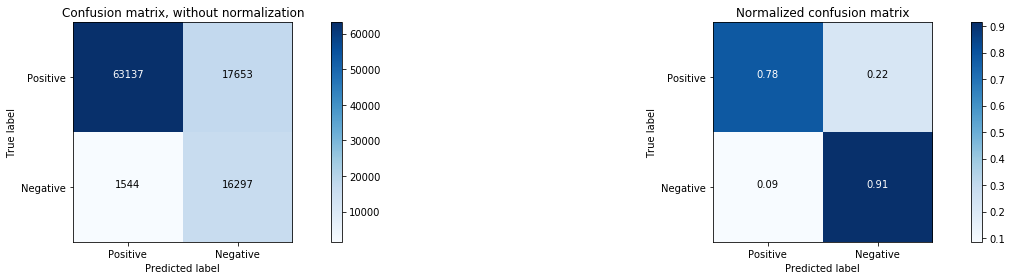

In [44]:
plot_confusion_matrix(rs_lin_bow_cm, ['Positive','Negative'])

#### Observations:

1. Linear SVM model with BOW seems to be a very good model compared to the best Logistic Regression model that we got in previous assignment.
2. AUC of 85% is achieved with f1 score of 63% and we have identified 91% of Negative reviews successfully though with very less 48% accuracy.
3. Linear SVM Model with BOW featurisation parameters searched with Grid Search CV seems to better of the above models.

#### Top 5 features of BOW - Linear SVM Model

In [45]:
print("Top 5 features of Linear SVM model for positive and negative classes respectively:")
print_top10(count_vec,model_rs_lin_bow,5)

Top 5 features of Linear SVM model for positive and negative classes respectively:
	-0.0172	great          		0.0214	disappoint     
	-0.0145	love           		0.0147	worst          
	-0.0121	best           		0.0145	wast           
	-0.0107	delici         		0.0143	return         
	-0.0097	perfect        		0.0140	money          


## ===================== SVM with TFIDF features =========================

## SVM without Kernel with Grid Search Cross Validation

In [17]:
# 10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(max_train_size= None, n_splits= 10)
X = tfidf_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'alpha': [10 ** x for x in range(-4, 5)]}
gs_lin_tfidf_model = GridSearchCV(estimator = SGDClassifier(loss = 'hinge',class_weight= 'balanced', random_state= 100)\
                                                    ,param_grid = param,cv = tscv)
gs_lin_tfidf_model.fit(X,Y)

print(gs_lin_tfidf_model.best_estimator_)

SGDClassifier(alpha=10, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


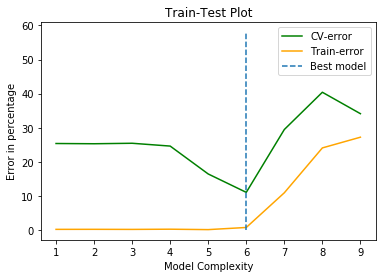

In [21]:
tscv_scores = gs_lin_tfidf_model.cv_results_.get('mean_test_score')
trcv_scores = gs_lin_tfidf_model.cv_results_.get('mean_train_score')
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(6,9),[0,9,15,18,38,48,49,50,58] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 10. So, picking up the best TFIDF model with alpha = 10

In [25]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = False)
train_X = X_scaler.fit_transform(tfidf_words)
tfidf_words_tst1 = tfidf_vec.transform(test['cleaned_sent'].values) 
tfidf_words_tst = X_scaler.transform(tfidf_words_tst1)
classifier_name = SGDClassifier(loss = 'hinge',class_weight= 'balanced', random_state= 100,alpha = 10)
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_gs_lin_tfidf = classifier_name.fit(train_X,train_y)
predtest_y_gs_lin_tfidf = model_gs_lin_tfidf.predict(tfidf_words_tst)

# Accuracy score
gs_lin_acc_tfidf = accuracy_score(test_y, predtest_y_gs_lin_tfidf, normalize=True)*100
print("Test Accuracy for Linear SVM model with TF-IDF:",gs_lin_acc_tfidf,'%')
# Precision-Recall, f-score
gs_lin_tfidf_pre, gs_lin_tfidf_recall, gs_lin_tfidf_fscore, gs_lin_tfidf_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_gs_lin_tfidf,pos_label = 1, average = 'binary')
print("Test Precision for Linear SVM model with TF-IDF for Negative label reviews:",gs_lin_tfidf_pre)
print("Test Recall for Linear SVM model with TF-IDF for Negative label reviews:",gs_lin_tfidf_recall)
print("Test fscore for Linear SVM model with TF-IDF for Negative label reviews:",gs_lin_tfidf_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_gs_lin_tfidf, pos_label = 1)
gs_lin_tfidf_auc_score = auc(fpr,tpr)
print("Test AUC for  Linear SVM model with TF-IDF:",gs_lin_tfidf_auc_score)
# Confusion matrix
gs_lin_tfidf_cm = confusion_matrix(test_y, predtest_y_gs_lin_tfidf)

Test Accuracy for Linear SVM model with TF-IDF: 88.42351796088451 %
Test Precision for Linear SVM model with TF-IDF for Negative label reviews: 0.6574341879503898
Test Recall for Linear SVM model with TF-IDF for Negative label reviews: 0.7516955327616165
Test fscore for Linear SVM model with TF-IDF for Negative label reviews: 0.7014121338912135
Test AUC for  Linear SVM model with TF-IDF: 0.8325998396572039


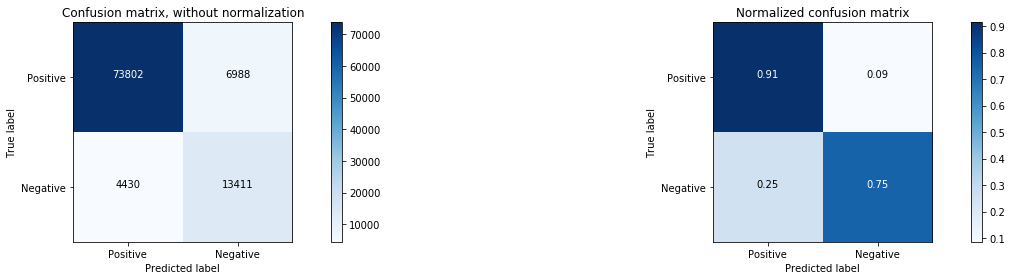

In [26]:
plot_confusion_matrix(gs_lin_tfidf_cm, ['Positive','Negative'])

#### Observations:

1. Linear SVM model with BOW seems to be a very good model compared to the best Logistic Regression model that we got in previous assignment.
2. AUC of 83% is achieved with f1 score of 70% and we have identified 75% of Negative reviews successfully though with high 66% accuracy.
3. Linear SVM Model with BOW featurisation parameters searched with Grid Search CV seems to better of the above models.

#### Top 5 features of TFIDF - Linear SVM Model

In [28]:
print("Top 5 features of Linear SVM model for positive and negative classes respectively:")
print_top10(count_vec,model_gs_lin_tfidf,5)

Top 5 features of Linear SVM model for positive and negative classes respectively:
	-0.0022	absolutuley    		0.0042	prefrozen      
	-0.0020	swimmer        		0.0039	podravka       
	-0.0019	alci           		0.0032	organza        
	-0.0019	trusti         		0.0025	onezip         
	-0.0018	adder          		0.0022	alberti        


## SVM without Kernel with Random Search Cross Validation

In [29]:
# 10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(max_train_size= None, n_splits= 10)
X = tfidf_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'alpha': np.random.uniform(10**-2,10**2,10)}
rs_lin_tfidf_model = RandomizedSearchCV(estimator = SGDClassifier(loss = 'hinge',class_weight= 'balanced', random_state= 100)\
                                                    ,param_distributions = param,cv = tscv)
rs_lin_tfidf_model.fit(X,Y)

print(rs_lin_tfidf_model.best_estimator_)

SGDClassifier(alpha=9.801410947227854, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


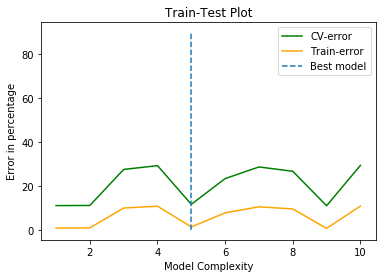

In [32]:
tscv_scores = rs_lin_tfidf_model.cv_results_.get('mean_test_score')
trcv_scores = rs_lin_tfidf_model.cv_results_.get('mean_train_score')
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9,10]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(5,10),[0,9,15,28,38,48,58,68,88,90] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 9.801410947227854. So, picking up the best TFIDF model with alpha = 9.801410947227854

In [34]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = False)
train_X = X_scaler.fit_transform(tfidf_words)
tfidf_words_tst1 = tfidf_vec.transform(test['cleaned_sent'].values) 
tfidf_words_tst = X_scaler.transform(tfidf_words_tst1)
classifier_name = SGDClassifier(loss = 'hinge',class_weight= 'balanced', random_state= 100,alpha = 9.801410947227854)
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_rs_lin_tfidf = classifier_name.fit(train_X,train_y)
predtest_y_rs_lin_tfidf = model_rs_lin_tfidf.predict(tfidf_words_tst)

# Accuracy score
rs_lin_acc_tfidf = accuracy_score(test_y, predtest_y_rs_lin_tfidf, normalize=True)*100
print("Test Accuracy for Linear SVM model with TF-IDF:",rs_lin_acc_tfidf,'%')
# Precision-Recall, f-score
rs_lin_tfidf_pre, rs_lin_tfidf_recall, rs_lin_tfidf_fscore, rs_lin_tfidf_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_rs_lin_tfidf,pos_label = 1, average = 'binary')
print("Test Precision for Linear SVM model with TF-IDF for Negative label reviews:",rs_lin_tfidf_pre)
print("Test Recall for Linear SVM model with TF-IDF for Negative label reviews:",rs_lin_tfidf_recall)
print("Test fscore for Linear SVM model with TF-IDF for Negative label reviews:",rs_lin_tfidf_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_rs_lin_tfidf, pos_label = 1)
rs_lin_tfidf_auc_score = auc(fpr,tpr)
print("Test AUC for  Linear SVM model with TF-IDF:",rs_lin_tfidf_auc_score)
# Confusion matrix
rs_lin_tfidf_cm = confusion_matrix(test_y, predtest_y_rs_lin_tfidf)

Test Accuracy for Linear SVM model with TF-IDF: 88.5096977623668 %
Test Precision for Linear SVM model with TF-IDF for Negative label reviews: 0.6608820330267972
Test Recall for Linear SVM model with TF-IDF for Negative label reviews: 0.7492293032901743
Test fscore for Linear SVM model with TF-IDF for Negative label reviews: 0.7022880710326529
Test AUC for  Linear SVM model with TF-IDF: 0.8321650910559054


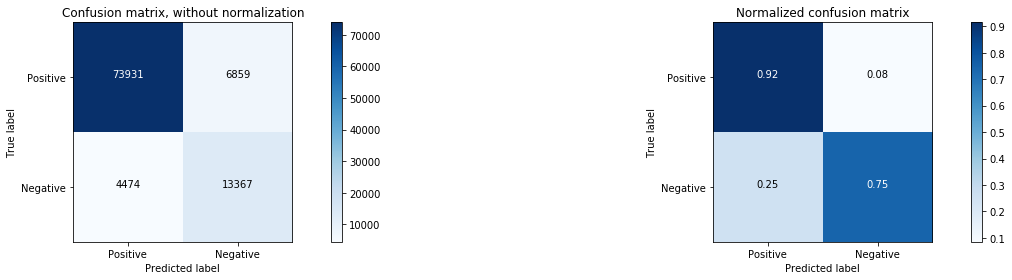

In [35]:
plot_confusion_matrix(rs_lin_tfidf_cm, ['Positive','Negative'])

#### Observations: 

1. AUC of 83% is achieved with f1 score of 70% and we have identified 75% of Negative reviews successfully though with high 66% accuracy. Similar to Grid Search results
2. Linear SVM Model with BOW featurisation parameters searched with Grid Search CV seems to better of the above models.

#### Top 5 features of TFIDF - Linear SVM Model

In [37]:
print("Top 5 features of Linear SVM model for positive and negative classes respectively:")
print_top10(count_vec,model_rs_lin_tfidf,5)

Top 5 features of Linear SVM model for positive and negative classes respectively:
	-0.0022	absolutuley    		0.0043	prefrozen      
	-0.0020	swimmer        		0.0039	podravka       
	-0.0020	alci           		0.0033	organza        
	-0.0019	trusti         		0.0025	onezip         
	-0.0019	adder          		0.0022	vecchia        


## ===================== SVM with AvgW2V features =========================

## SVM without Kernel with Grid Search Cross Validation

In [24]:
# 10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(max_train_size= None, n_splits= 10)
X = sent_vect[:train.shape[0]] 
X = StandardScaler(with_mean = True).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'alpha': [10 ** x for x in range(-4, 5)]}
gs_lin_avgw2v_model = GridSearchCV(estimator = SGDClassifier(loss = 'hinge',class_weight= 'balanced', random_state= 100)\
                                                    ,param_grid = param,cv = tscv)
gs_lin_avgw2v_model.fit(X,Y)

print(gs_lin_avgw2v_model.best_estimator_)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=100, shuffle=True,
       tol=None, verbose=0, warm_start=False)


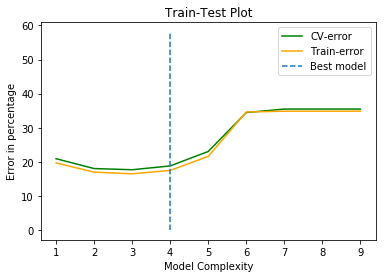

In [28]:
tscv_scores = gs_lin_avgw2v_model.cv_results_.get('mean_test_score')
trcv_scores = gs_lin_avgw2v_model.cv_results_.get('mean_train_score')
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(4,9),[0,9,15,18,38,48,49,50,58] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

In [26]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = True)
train_X = X_scaler.fit_transform(sent_vect[:train.shape[0]] )
avgw2v_tst = X_scaler.transform(sent_vect[train.shape[0]:])
classifier_name = SGDClassifier(loss = 'hinge',class_weight= 'balanced', random_state= 100,alpha = 0.01)
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_gs_lin_avgw2v = classifier_name.fit(train_X,train_y)
predtest_y_gs_lin_avgw2v = model_gs_lin_avgw2v.predict(avgw2v_tst)

# Accuracy score
gs_lin_acc_avgw2v = accuracy_score(test_y, predtest_y_gs_lin_avgw2v, normalize=True)*100
print("Test Accuracy for Linear SVM model with Avg. Word2Vec:",gs_lin_acc_avgw2v,'%')
# Precision-Recall, f-score
gs_lin_avgw2v_pre, gs_lin_avgw2v_recall, gs_lin_avgw2v_fscore, gs_lin_avgw2v_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_gs_lin_avgw2v,pos_label = 1, average = 'binary')
print("Test Precision for Linear SVM model with Avg. Word2Vec for Negative label reviews:",gs_lin_avgw2v_pre)
print("Test Recall for Linear SVM model with Avg. Word2Vec for Negative label reviews:",gs_lin_avgw2v_recall)
print("Test fscore for Linear SVM model with Avg. Word2Vec for Negative label reviews:",gs_lin_avgw2v_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_gs_lin_avgw2v, pos_label = 1)
gs_lin_avgw2v_auc_score = auc(fpr,tpr)
print("Test AUC for  Linear SVM model with Avg. Word2Vec:",gs_lin_avgw2v_auc_score)
# Confusion matrix
gs_lin_avgw2v_cm = confusion_matrix(test_y, predtest_y_gs_lin_avgw2v)

Test Accuracy for Linear SVM model with Avg. Word2Vec: 82.5419999797224 %
Test Precision for Linear SVM model with Avg. Word2Vec for Negative label reviews: 0.5101787000065457
Test Recall for Linear SVM model with Avg. Word2Vec for Negative label reviews: 0.873717840928199
Test fscore for Linear SVM model with Avg. Word2Vec for Negative label reviews: 0.6441987808657919
Test AUC for  Linear SVM model with Avg. Word2Vec: 0.8442360711015546


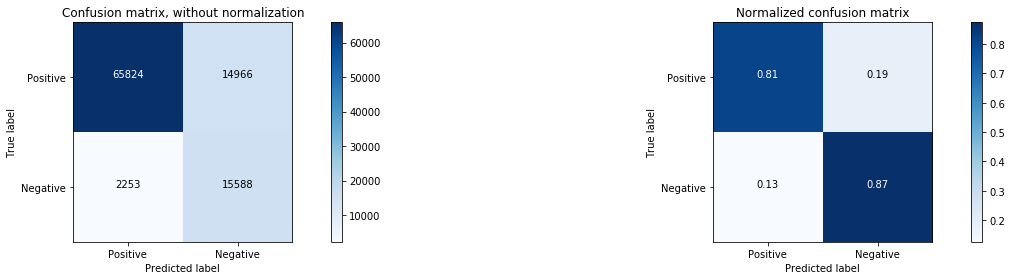

In [27]:
plot_confusion_matrix(gs_lin_avgw2v_cm, ['Positive','Negative'])

#### Observations: 

1. AUC of 84% is achieved with f1 score of 64% and we have identified 87% of Negative reviews successfully though with 51% accuracy.
2. Linear SVM Model with BOW featurisation parameters searched with Grid Search CV seems to better of the above models.

## SVM without Kernel with Random Search Cross Validation

In [34]:
# 10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(max_train_size= None, n_splits= 10)
X = sent_vect[:train.shape[0]] 
X = StandardScaler(with_mean = True).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'alpha': np.random.uniform(10**-2,10**2,10)}
rs_lin_avgw2v_model = RandomizedSearchCV(estimator = SGDClassifier(loss = 'hinge',class_weight= 'balanced', random_state= 100)\
                                                    ,param_distributions = param,cv = tscv)
rs_lin_avgw2v_model.fit(X,Y)

print(rs_lin_avgw2v_model.best_estimator_)

SGDClassifier(alpha=19.946786409205625, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5, random_state=100,
       shuffle=True, tol=None, verbose=0, warm_start=False)


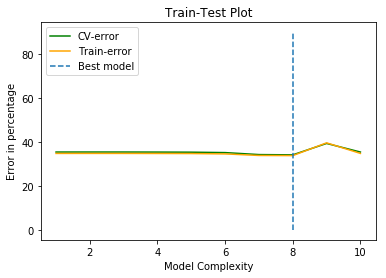

In [38]:
tscv_scores = rs_lin_avgw2v_model.cv_results_.get('mean_test_score')
trcv_scores = rs_lin_avgw2v_model.cv_results_.get('mean_train_score')
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9,10]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(8,10),[0,9,15,28,38,48,58,68,88,90] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

In [37]:
# ====================================== Model Performance measures on Test Data ===============================================
# Checking accuracy of the model on test data
X_scaler = StandardScaler(with_mean = True)
train_X = X_scaler.fit_transform(sent_vect[:train.shape[0]] )
avgw2v_tst = X_scaler.transform(sent_vect[train.shape[0]:])
classifier_name = SGDClassifier(loss = 'hinge',class_weight= 'balanced', random_state= 100,alpha = 19.946786409205625)
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
# Positive = 0 ; Negative = 1
model_rs_lin_avgw2v = classifier_name.fit(train_X,train_y)
predtest_y_rs_lin_avgw2v = model_rs_lin_avgw2v.predict(avgw2v_tst)

# Accuracy score
rs_lin_acc_avgw2v = accuracy_score(test_y, predtest_y_rs_lin_avgw2v, normalize=True)*100
print("Test Accuracy for Linear SVM model with Avg. Word2Vec:",rs_lin_acc_avgw2v,'%')
# Precision-Recall, f-score
rs_lin_avgw2v_pre, rs_lin_avgw2v_recall, rs_lin_avgw2v_fscore, rs_lin_avgw2v_suprt = \
                precision_recall_fscore_support(test_y,predtest_y_rs_lin_avgw2v,pos_label = 1, average = 'binary')
print("Test Precision for Linear SVM model with Avg. Word2Vec for Negative label reviews:",rs_lin_avgw2v_pre)
print("Test Recall for Linear SVM model with Avg. Word2Vec for Negative label reviews:",rs_lin_avgw2v_recall)
print("Test fscore for Linear SVM model with Avg. Word2Vec for Negative label reviews:",rs_lin_avgw2v_fscore)
# ROC, AUC
fpr, tpr, thresholds = roc_curve(test_y,predtest_y_rs_lin_avgw2v, pos_label = 1)
rs_lin_avgw2v_auc_score = auc(fpr,tpr)
print("Test AUC for  Linear SVM model with Avg. Word2Vec:",rs_lin_avgw2v_auc_score)
# Confusion matrix
rs_lin_avgw2v_cm = confusion_matrix(test_y, predtest_y_rs_lin_avgw2v)

Test Accuracy for Linear SVM model with Avg. Word2Vec: 83.53864403686467 %
Test Precision for Linear SVM model with Avg. Word2Vec for Negative label reviews: 0.7977736549165121
Test Recall for Linear SVM model with Avg. Word2Vec for Negative label reviews: 0.12050894008183398
Test fscore for Linear SVM model with Avg. Word2Vec for Negative label reviews: 0.20938839111803662
Test AUC for  Linear SVM model with Avg. Word2Vec: 0.5568815278451007


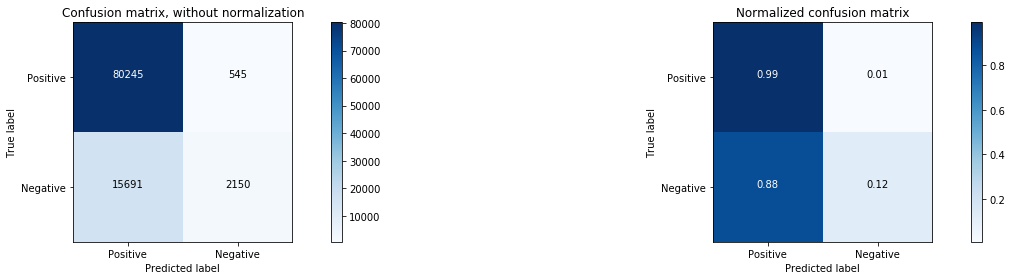

In [39]:
plot_confusion_matrix(rs_lin_avgw2v_cm, ['Positive','Negative'])

#### Observations: 

1. This seems to be a very bad model, got results worse than the baseline model.
2. Linear SVM Model with BOW featurisation parameters searched with Grid Search CV seems to better of the above models.

## ===================== SVM with TF-IDFW2V features =========================

## SVM with RBF Kernel with Grid Search Cross Validation

In [ ]:
# 10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(max_train_size= None, n_splits= 10)
X = bow_words
X = StandardScaler(with_mean = False).fit_transform(X)
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
param = {'C': np.logspace(-3,4,6),'gamma': np.logspace(-3,4,6)}
gs_rbf_bow_model = GridSearchCV(estimator = SVC(kernel = 'rbf',class_weight= 'balanced', random_state= 100)\
                                                    ,param_grid = param,cv = tscv)
gs_rbf_bow_model.fit(X,Y)

print(gs_rbf_bow_model.best_estimator_)

In [ ]:
tscv_scores = gs_rbf_bow_model.cv_results_.get('mean_test_score')
trcv_scores = gs_rbf_bow_model.cv_results_.get('mean_train_score')
# Bias-Variance plot
x = [1,2,3,4,5,6]
ts_error = [100 - x*100 for x in tscv_scores]
tr_error = [100 - x*100 for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(3,6),[3,9,15,28,38,48] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

# TF-IDF Naive Bayes Model

In [105]:
# 10 fold - Time based Cross Validation 
tscv = TimeSeriesSplit(max_train_size= None, n_splits= 10)
X = tfidf_words
Y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0)) # Target Variable preparation
alpha = [0.0001,0.001,0.01,0.1,0,10,100,1000,10000]
trcv_scores = []
tscv_scores = []
for i in alpha:
    classifier_name = MultinomialNB(alpha=i,fit_prior=False,class_prior=[0.5,0.5])
    for train_index, test_index in tscv.split(X):
        tsscore = []
        trscore = []
        train_x, test_x = X[train_index], X[test_index]
        train_y, test_y = Y[train_index], Y[test_index]
        modelNB = classifier_name.fit(train_x,train_y) 
        test_ypred = modelNB.predict(test_x)
        train_ypred = modelNB.predict(train_x)
        tsscore.append(accuracy_score(test_y,test_ypred,normalize = True)*100)
        trscore.append(accuracy_score(train_y,train_ypred,normalize = True)*100)
    trcv_scores.append(np.array(trscore).mean())
    tscv_scores.append(np.array(tsscore).mean())
        
best_alpha = alpha[tscv_scores.index(max(tscv_scores))]

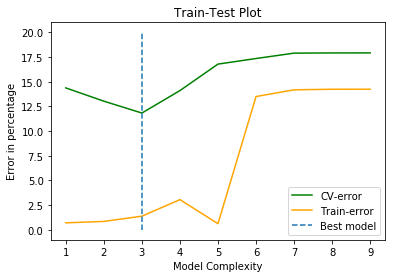

In [107]:
# Bias-Variance plot
x = [1,2,3,4,5,6,7,8,9]
ts_error = [100 - x for x in tscv_scores]
tr_error = [100 - x for x in trcv_scores]
plt.plot(x, ts_error, color='g', label ='CV-error')
plt.plot(x, tr_error, color='orange', label = 'Train-error')
plt.xlabel('Model Complexity')
plt.ylabel('Error in percentage')
plt.title('Train-Test Plot')
plt.plot(np.repeat(3,9),[0,3,5,8,10,12,16,17,20] , linestyle='--',label = 'Best model')
plt.legend()
plt.show()

Low Cross Validation error and low training error is observed at alpha = 0.01. So, picking up the model with 
laplace smooting coefficient = 0.01.

In [113]:
# Checking accuracy of the model on test data
tfidf_words_tst = tfidf_vec.transform(test['cleaned_sent'].values)
classifier_name = MultinomialNB(alpha = 0.01,fit_prior=False,class_prior=[0.5,0.5])
train_y = np.array(train['Score'].apply(lambda x: 1 if x =='Negative' else 0))
test_y = np.array(test['Score'].apply(lambda x: 1 if x =='Negative' else 0))
modelNB_tfidf = classifier_name.fit(tfidf_words,train_y)
predtest_y_tfidf = modelNB_tfidf.predict(tfidf_words_tst)

# Accuracy score
tfidf_acc = accuracy_score(test_y, predtest_y_tfidf, normalize=True)*100
print("Test Accuracy for NB model with TF-IDF:",tfidf_acc,'%')
# Precision-Recall, f-score
tfidf_pre, tfidf_recall, tfidf_fscore, tfidf_suprt = precision_recall_fscore_support(test_y,predtest_y_tfidf\
                                                                                     ,pos_label = 1, average = 'binary')
print("Test Precision for NB model with TF-IDF for Positive label reviews:",tfidf_pre)
print("Test Recall for NB model with TF-IDF for Positive label reviews:",tfidf_recall)
print("Test fscore for NB model with TF-IDF for Positive label reviews:",tfidf_fscore)
# ROC, AUC
tfidf_fpr, tfidf_tpr, tfidf_thresholds = roc_curve(test_y,predtest_y_tfidf, pos_label = 1)
tfidf_auc_score = auc(tfidf_fpr,tfidf_tpr)
print("Test AUC for NB model with TF-IDF:",tfidf_auc_score)
# Confusion matrix
tfidf_cm = confusion_matrix(test_y, predtest_y_tfidf)

Test Accuracy for NB model with TF-IDF: 89.36237085703279 %
Test Precision for NB model with TF-IDF for Positive label reviews: 0.7258867646154792
Test Recall for NB model with TF-IDF for Positive label reviews: 0.6618463090633933
Test fscore for NB model with TF-IDF for Positive label reviews: 0.6923888823736367
Test AUC for NB model with TF-IDF: 0.8033269173736325


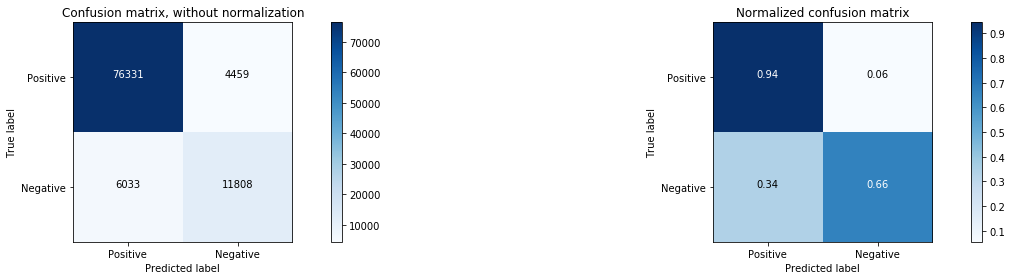

In [114]:
plot_confusion_matrix(tfidf_cm, ['Positive','Negative'])

#### Observations:

1. Precision has come down from 84% to 72% but the recall rate has improved a lot with the TFIDF based NB model.
2. AUC is good for the model (80%)

In [110]:
# Top 10 features with Naive Bayes Model
print_top10(count_vec,modelNB_tfidf,n=10)

	-8.3894	prefrozen      
	-8.4159	podravka       
	-9.0251	organza        
	-9.0329	incisor        
	-9.1617	vecchia        
	-9.1624	microorgan     
	-9.1844	uncrush        
	-9.2316	vapid          
	-9.2773	simplehuman    
	-9.4081	lalabar        


## Conclusion:

In [145]:
table = [["Bag Of Words", bow_acc, bow_pre,bow_recall, bow_fscore,bow_auc_score],
         ["TF-IDF", tfidf_acc, tfidf_pre,tfidf_recall,tfidf_fscore,tfidf_auc_score]]
pd.DataFrame(table, columns = ["Model","Accuracy", "Precision", "Recall","f-score","AUC"])

,Model,Accuracy,Precision,Recall,f-score,AUC
0,Bag Of Words,87.678316,0.847762,0.388599,0.532918,0.686594
1,TF-IDF,89.362371,0.725887,0.661846,0.692389,0.803327


Naive Bayes Model is a simple yet powerful model which takes a naive assumption that all the features are independent or 
or uncorelated to each other. The best accuracy that we could get using Naive Bayes is 89%. The Naive Bayes Model built with Term Frequency- Inverse Document Frequency vectors seems to be the best of all with an AUC of 80%. We can keep this as baseline measure for other algorithms.